# Shipment Booking Prediction 

Problem statement:  Predict the next booking date and shipment type for each company based on this data. 

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, 
    precision_recall_curve, 
    average_precision_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

## 1. Data Loading and Initial Exploration

In [ ]:
# Load the shipment booking data from CSV file
df = pd.read_csv("D:\\Shipment_project\\shipment_booking_data_2021_2025.csv")
df.head()

,company_name,shipment_type,booking_date
0,BlueDart,Express,2021-01-01
1,BlueDart,Surface,2021-01-01
2,BlueDart,Surface,2021-01-01
3,BlueDart,Air,2021-01-01
4,BlueDart,Surface,2021-01-01


In [ ]:
# Check data types and null values to ensure data quality
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206559 entries, 0 to 206558
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   company_name   206559 non-null  object
 1   shipment_type  206559 non-null  object
 2   booking_date   206559 non-null  object
dtypes: object(3)
memory usage: 4.7+ MB


company_name     0
shipment_type    0
booking_date     0
dtype: int64

In [129]:
df.describe()

,company_name,shipment_type,booking_date
count,206559,206559,206559
unique,8,4,1826
top,Delhivery,Surface,2025-10-20
freq,36946,82825,169


Pattern in data

In [130]:
print(df.columns.tolist())

['company_name', 'shipment_type', 'booking_date']


In [ ]:
# Check distribution of shipment types to identify class imbalance
category_counts = df['shipment_type'].value_counts()
category_counts

shipment_type
Surface          82825
Air              72412
Express          41115
International    10207
Name: count, dtype: int64

## 2. Time Series Analysis

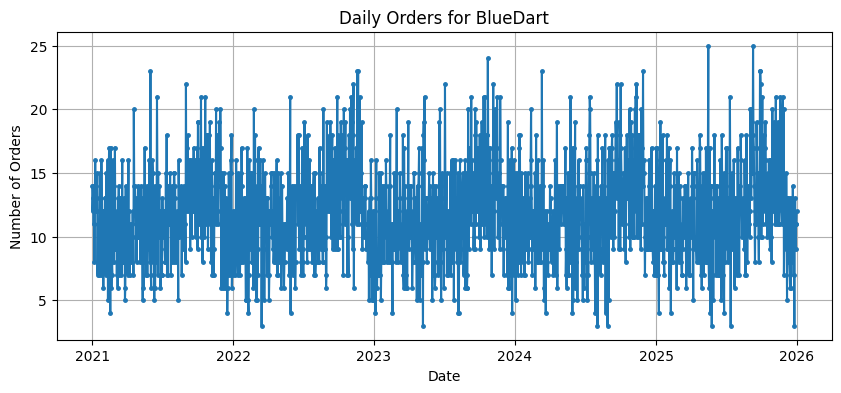

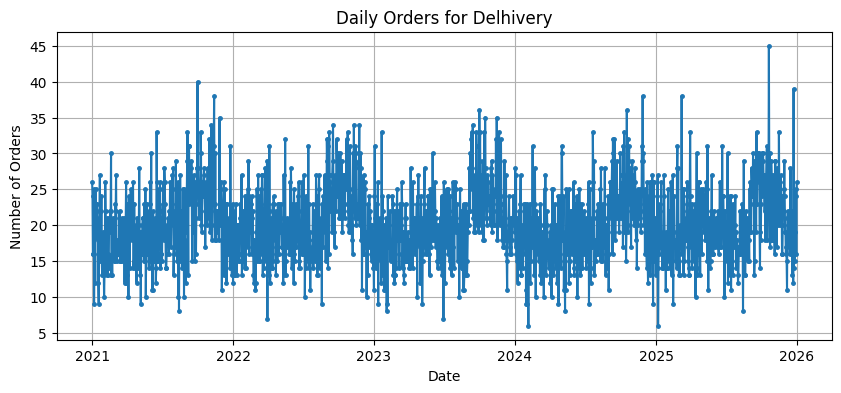

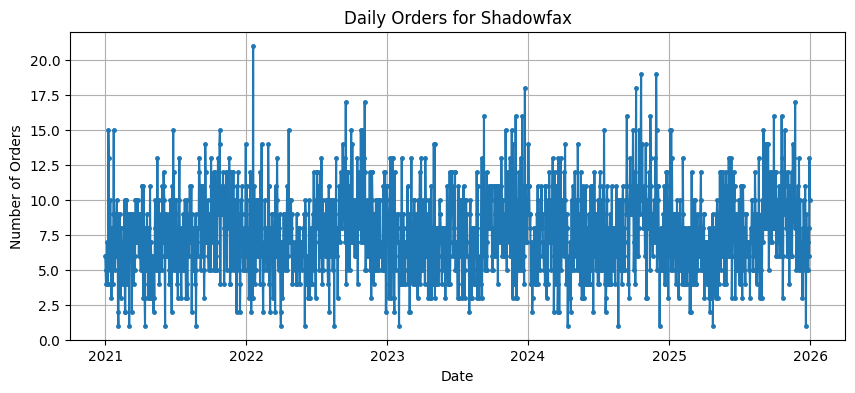

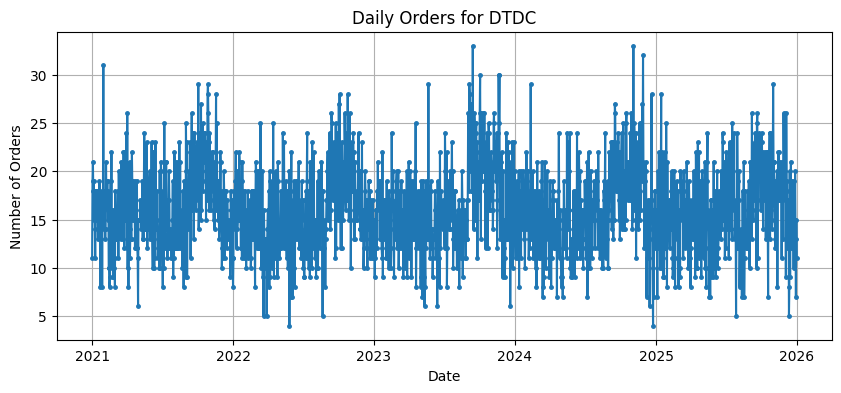

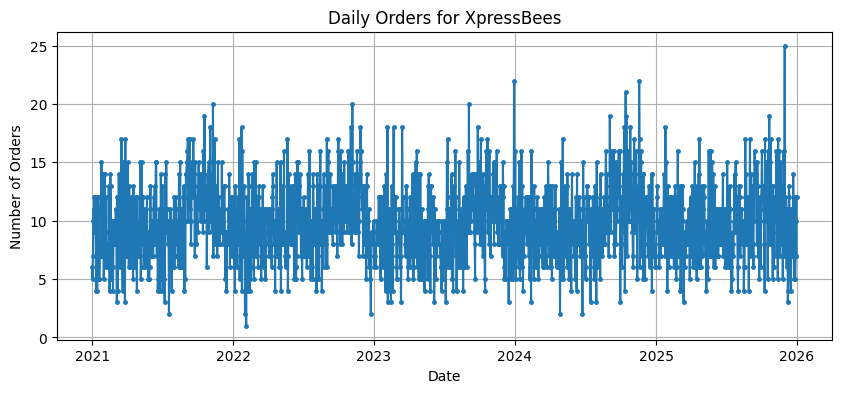

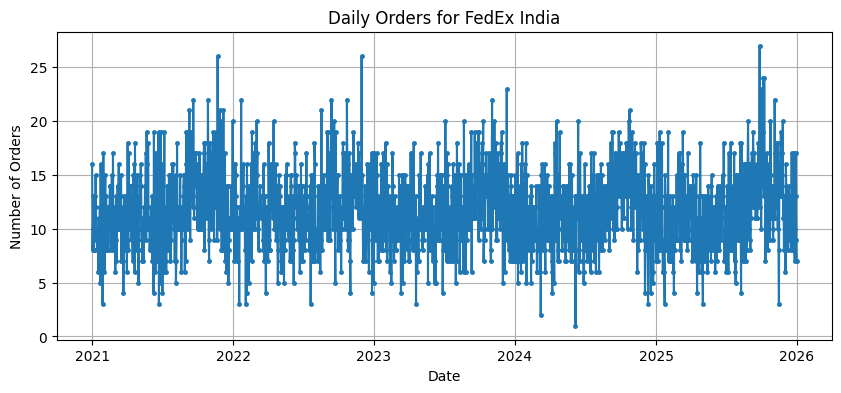

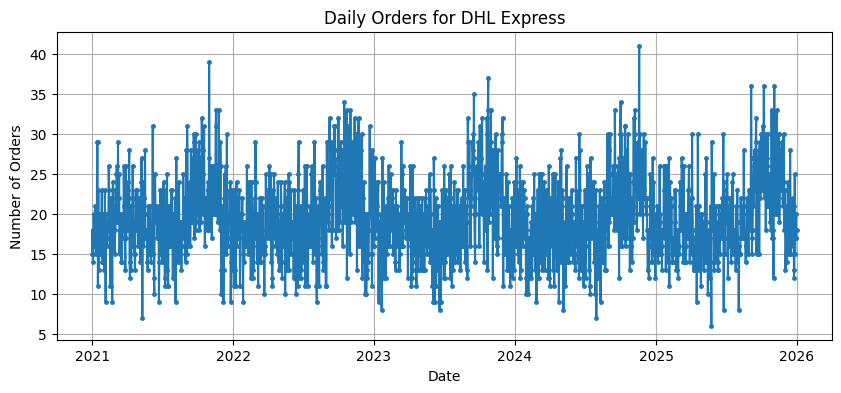

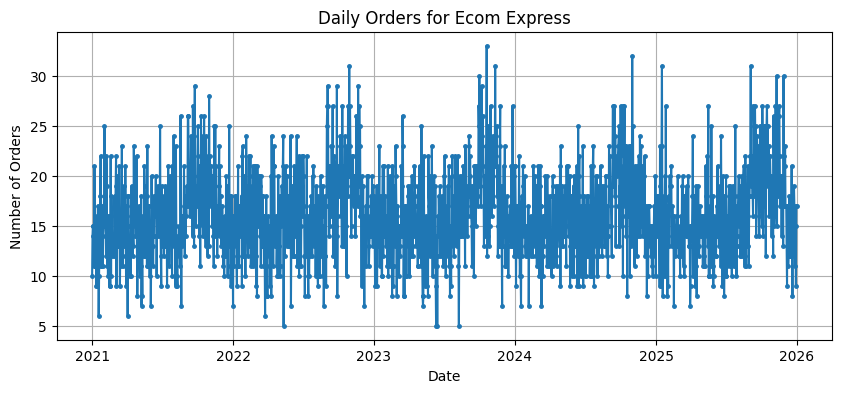

In [ ]:
# Plot daily order trends for each company to visualize patterns
# 1. Ensure booking_date is in datetime format (if not already done)
df['booking_date'] = pd.to_datetime(df['booking_date'])

# Optional: Sort by date for clean time series plots
df = df.sort_values('booking_date')

# Get a list of unique company names
companies = df['company_name'].unique()

# Loop through each company and create a new plot
for company in companies:
    # Filter the DataFrame for the current company
    company_df = df[df['company_name'] == company]

    # Group by date and count orders for this specific company
    # This creates a Series with dates as index and order counts as values
    daily_orders = company_df.groupby(company_df['booking_date'].dt.date).size()

    # Create a new plot/figure
    plt.figure(figsize=(10, 4))
    
    # Plot the data
    daily_orders.plot(kind='line', marker='.', linestyle='-', markersize=5)
    
    # Add titles and labels
    plt.title(f'Daily Orders for {company}')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.grid(True)
    
    # Display the plot
    plt.show()

### Proof that booking occurs every day(Per Company)

Before moving forward with prediction model for next booking date, verifying whether bookings occur daily or if there are any gaps that requires forecasting. Since, predicting date only matters if there are irregular booking days.

In [133]:
# Ensuring booking_date is in datetime format
df["booking_date"] = pd.to_datetime(df["booking_date"])
# to know the number of orders per company per day
daily = (
    df.groupby(["company_name", "booking_date"])
      .size()
      .reset_index(name="order_count")
)


In [ ]:
# Calculate daily booking coverage for each company to confirm daily activity
summary = []

for company, g in daily.groupby("company_name"):
    total_days = (g["booking_date"].max() - g["booking_date"].min()).days + 1
    active_days = g["booking_date"].nunique()
    
    summary.append({
        "company": company,
        "active_days": active_days,
        "total_days": total_days,
        "coverage_pct": round(active_days / total_days * 100, 2)
    })

coverage_df = pd.DataFrame(summary)
coverage_df

,company,active_days,total_days,coverage_pct
0,BlueDart,1826,1826,100.00
1,DHL Express,1826,1826,100.00
2,DTDC,1826,1826,100.00
3,Delhivery,1826,1826,100.00
4,Ecom Express,1826,1826,100.00
5,FedEx India,1826,1826,100.00
6,Shadowfax,1825,1826,99.95
7,XpressBees,1826,1826,100.00


The above result shows that every company is active that is there is order  for each company everyday.

In [135]:
presence = (
    daily.assign(present=1)
         .pivot_table(
             index="booking_date",
             columns="company_name",
             values="present",
             fill_value=0
         )
)


In [136]:
absence = (presence == 0).sum()
absence

company_name
BlueDart        0
DHL Express     0
DTDC            0
Delhivery       0
Ecom Express    0
FedEx India     0
Shadowfax       1
XpressBees      0
dtype: int64

In [137]:
weekly_activity = presence.rolling(7).sum()

weekly_activity.min()

company_name
BlueDart        7.0
DHL Express     7.0
DTDC            7.0
Delhivery       7.0
Ecom Express    7.0
FedEx India     7.0
Shadowfax       6.0
XpressBees      7.0
dtype: float64

### Modeling Decision: Deterministic Date Prediction

The above results show that bookings occur daily for all companies, so predicting the next booking date using a time-series or machine learning model would be unnecessary and misleading.

Instead, we define:

**Next Booking Date = max(booking_date) + 1 day** which gives next date from the last booking date

This allows the modeling effort to focus on the non-trivial task:
**predicting the shipment type mix for the next booking day**.

In [ ]:
# Extract temporal features for modeling
# Extract day of week (0=Mon, 6=Sun) and Month (1-12)
df['day_of_week'] = df['booking_date'].dt.day_name()
df['month'] = df['booking_date'].dt.month_name()
df['is_weekend'] = df['booking_date'].dt.dayofweek >= 5

## 3. Visualizations: Factors Affecting Shipment Type

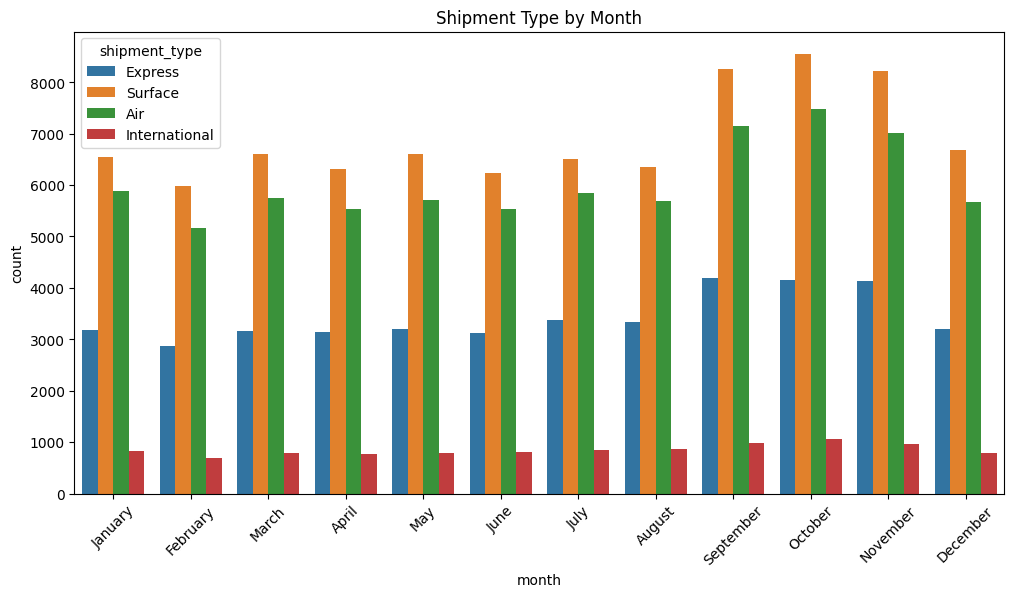

In [139]:
# Shipment Type Distribution by Month
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='month', hue='shipment_type', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Shipment Type by Month')
plt.xticks(rotation=45)
plt.show()

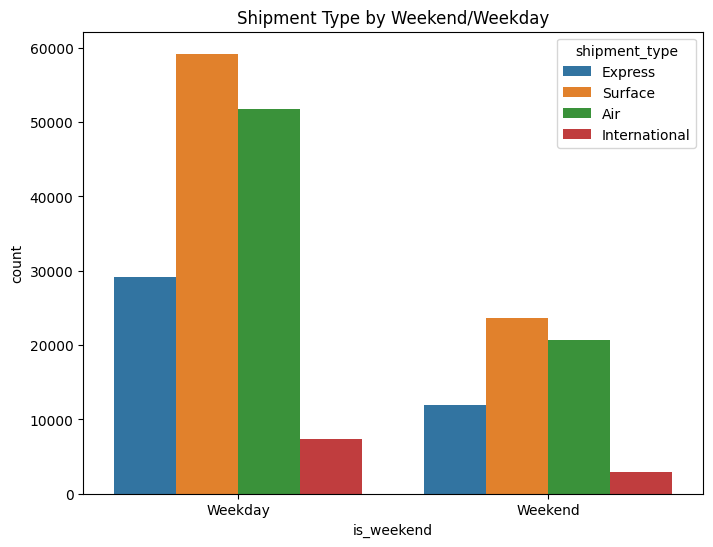

In [140]:
# Shipment Type Distribution by Weekend/Weekday
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='is_weekend', hue='shipment_type')
plt.title('Shipment Type by Weekend/Weekday')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

### Key Observations from the above plots

- Surface and Air shipments dominate daily volumes
- Express and International shipments occur less frequently
- Shipment patterns vary by month and by weekday/weekend

This confirms that shipment type prediction is a class-imbalanced problem
with strong temporal dependencies.


## 4. Feature Engineering

To capture temporal and behavioral patterns, we engineer features that encode:
- Weekly structure
- Seasonal cyclicality
- Recent shipment momentum
- Company-specific behavior

In [ ]:
# Aggregate data to daily level per company and shipment type
daily = (
    df.groupby(["company_name", "booking_date", "shipment_type"])
      .size()
      .reset_index(name="count")
)

daily_pivot = (
    daily.pivot_table(
        index=["company_name", "booking_date"],
        columns="shipment_type",
        values="count",
        fill_value=0
    )
    .reset_index()
)

In [ ]:
# Calculate total orders and percentages for each shipment type
shipment_cols = ["Air", "Express", "International", "Surface"]

daily_pivot["total_orders"] = daily_pivot[shipment_cols].sum(axis=1)
for col in shipment_cols:
    daily_pivot[f"{col}_pct"] = daily_pivot[col] / daily_pivot["total_orders"]

In [ ]:
# Define threshold for significant shipments (20% of daily volume)
THRESHOLD = 0.20   # shipment is significant if ≥ 20% of daily volume

In [ ]:
# Create binary labels for significant shipments
for col in shipment_cols:
    daily_pivot[f"{col}_label"] = (
        daily_pivot[f"{col}_pct"] >= THRESHOLD
    ).astype(int)

calender features

In [ ]:
# Add calendar-based features for temporal patterns
# to encode weekday info
daily_pivot["day_of_week"] = daily_pivot["booking_date"].dt.weekday
daily_pivot["is_weekend"] = daily_pivot["day_of_week"].isin([5, 6]).astype(int)

daily_pivot["month"] = daily_pivot["booking_date"].dt.month

#Month is encoded using sine and cosine transformations to preserve its cyclic nature
daily_pivot["month_sin"] = np.sin(2 * np.pi * daily_pivot["month"] / 12)
daily_pivot["month_cos"] = np.cos(2 * np.pi * daily_pivot["month"] / 12)

daily_pivot["is_mon_fri"] = daily_pivot["day_of_week"].isin([0, 4]).astype(int)
daily_pivot["is_midweek"] = daily_pivot["day_of_week"].isin([1, 2, 3]).astype(int)

In [ ]:
# Compute rolling statistics for momentum and trends
# Rolling shipment volume and order statistics (7-day and 30-day windows) so that they capture short-term and long-term patterns
for w in [7, 30]:
    for col in shipment_cols:
        daily_pivot[f"{col}_ratio_{w}d"] = (
            daily_pivot.groupby("company_name")[col]
            .rolling(w)
            .sum()
            .reset_index(level=0, drop=True)
        )

    daily_pivot[f"orders_avg_{w}d"] = (
        daily_pivot.groupby("company_name")["total_orders"]
        .rolling(w)
        .mean()
        .reset_index(level=0, drop=True)
    )

In [ ]:
# Remove rows with NaN values (from rolling windows)
daily_pivot = daily_pivot.dropna().reset_index(drop=True)

In [ ]:
# Encode company names as integers for modeling
le_company = LabelEncoder()
daily_pivot["company_enc"] = le_company.fit_transform(daily_pivot["company_name"])

In [ ]:
# Define feature columns for the model
feature_cols = (
    ["company_enc", "day_of_week", "is_weekend", "month_sin", "month_cos"]
    + [f"{c}_ratio_7d" for c in shipment_cols]
    + [f"{c}_ratio_30d" for c in shipment_cols]
    + ["orders_avg_7d", "orders_avg_30d"]
)

In [ ]:
# Prepare feature matrix X and target matrix Y
X = daily_pivot[feature_cols]

In [ ]:
# Prepare multi-label targets
label_cols = [f"{c}_label" for c in shipment_cols]
Y = daily_pivot[label_cols]

##  Note:  Multi-Label Target Construction

For each shipment type, a binary label is assigned based on whether the shipment
contributes at least a threshold percentage of daily volume.

This formulation:
- Avoids label suppression
- Reflects real operational coexistence( that is multiple shipment can  occur in a single day for each company)
- Enables meaningful evaluation for minority shipment types

## 5. Train-Test splits(Time-Aware)


To simulate real-world forecasting conditions, data is split chronologically
within each company.Models are trained on historical data and evaluated on the most recent period, preventing temporal leakage.

In [ ]:
# Perform time-aware train-test split per company
train_parts, test_parts = [], []
TEST_RATIO = 0.10

for company, g in daily_pivot.groupby("company_name"):
    g = g.sort_values("booking_date")
    split_idx = int(len(g) * (1 - TEST_RATIO))
    train_parts.append(g.iloc[:split_idx])
    test_parts.append(g.iloc[split_idx:])

train_df = pd.concat(train_parts)
test_df = pd.concat(test_parts)

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

Y_train = train_df[label_cols]
Y_test = test_df[label_cols]

## 6. Model Training and Evaluation

In [ ]:
# Define pipelines for models to streamline preprocessing and training
rf_pipeline = Pipeline([
    ('classifier', OneVsRestClassifier(RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="lbfgs"
    )))
])

In [ ]:
# Perform hyperparameter tuning for Random Forest using GridSearchCV
param_grid_rf = {
    'classifier__estimator__n_estimators': [200, 400, 500],
    
    'classifier__estimator__max_depth': [5, 10, 15],
    
    'classifier__estimator__min_samples_leaf': [10, 20, 40],
    
    'classifier__estimator__max_features': ['sqrt', 0.5]
}


grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid_rf, 
    cv=3,  # 3-fold CV for speed
    scoring='f1_macro',  # Suitable for multi-label
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, Y_train)

rf_pipeline = grid_search_rf.best_estimator_

print("Best parameters for RF:", grid_search_rf.best_params_)
print("Best CV score for RF:", grid_search_rf.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for RF: {'classifier__estimator__max_depth': 10, 'classifier__estimator__max_features': 0.5, 'classifier__estimator__min_samples_leaf': 20, 'classifier__estimator__n_estimators': 200}
Best CV score for RF: 0.6348439797099049


In [ ]:
# Evaluate Random Forest on test set
Y_pred_rf = rf_pipeline.predict(X_test)

for i, col in enumerate(shipment_cols):
    print(f"\n=== {col} (Random Forest) ===")
    print(classification_report(Y_test.iloc[:, i], Y_pred_rf[:, i]))


=== Air (Random Forest) ===
              precision    recall  f1-score   support

           0       0.22      0.37      0.27       166
           1       0.91      0.83      0.87      1274

    accuracy                           0.78      1440
   macro avg       0.56      0.60      0.57      1440
weighted avg       0.83      0.78      0.80      1440


=== Express (Random Forest) ===
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       725
           1       0.60      0.65      0.63       715

    accuracy                           0.61      1440
   macro avg       0.61      0.61      0.61      1440
weighted avg       0.61      0.61      0.61      1440


=== International (Random Forest) ===
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1409
           1       0.11      0.39      0.17        31

    accuracy                           0.92      1440
   macro avg       0.55    

In [ ]:
# Train Logistic Regression pipeline
lr_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=3000)))])

In [ ]:
# Evaluate Logistic Regression on test set
Y_pred_lr = lr_pipeline.predict(X_test)

for i, col in enumerate(shipment_cols):
    print(f"\n=== {col} (Logistic Regression) ===")
    print(classification_report(Y_test.iloc[:, i], Y_pred_lr[:, i]))


=== Air (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.17      0.57      0.27       166
           1       0.92      0.64      0.76      1274

    accuracy                           0.64      1440
   macro avg       0.55      0.61      0.51      1440
weighted avg       0.83      0.64      0.70      1440


=== Express (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       725
           1       0.61      0.64      0.62       715

    accuracy                           0.61      1440
   macro avg       0.62      0.61      0.61      1440
weighted avg       0.62      0.61      0.61      1440


=== International (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1409
           1       0.07      0.65      0.12        31

    accuracy                           0.80      1440
   macro 

### Model Evaluation

Models are evaluated using:
- Precision–Recall curves (suitable for class imbalance)
- Per-label confusion matrices

Evaluation is performed independently for each shipment type, as required in
multi-label classification.

In [ ]:
# Get predicted probabilities for RF evaluation
Y_test_pred_proba_rf = rf_pipeline.predict_proba(X_test)

PR curve for Random forest Classifier

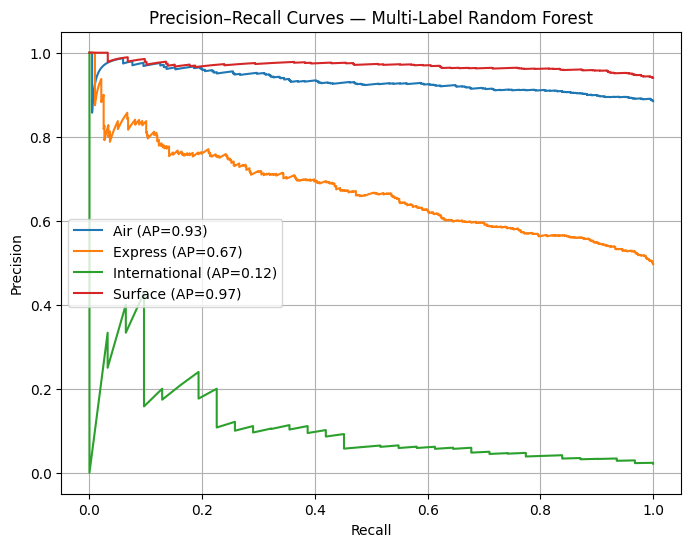

In [ ]:
# Plot Precision-Recall curves for Random Forest
plt.figure(figsize=(8, 6))

for j, col in enumerate(shipment_cols):
    y_true = Y_test.iloc[:, j]          # binary true labels
    y_score = Y_test_pred_proba_rf[:, j]   # predicted probabilities

    precision, recall, _ = precision_recall_curve(
        y_true,
        y_score
    )

    ap = average_precision_score(
        y_true,
        y_score
    )

    plt.plot(
        recall,
        precision,
        label=f"{col} (AP={ap:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Multi-Label Random Forest")
plt.legend()
plt.grid()
plt.show()

Confusion matrix for Random Forest classifier

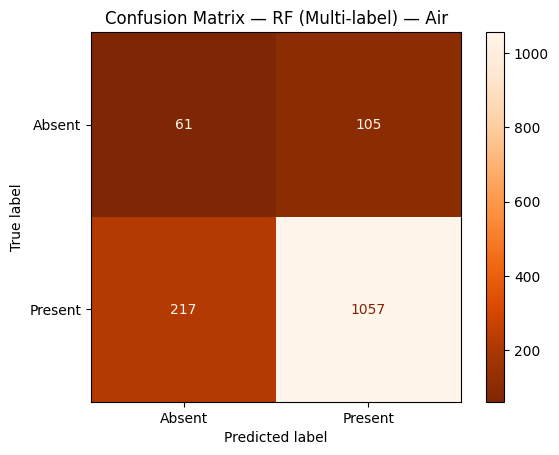

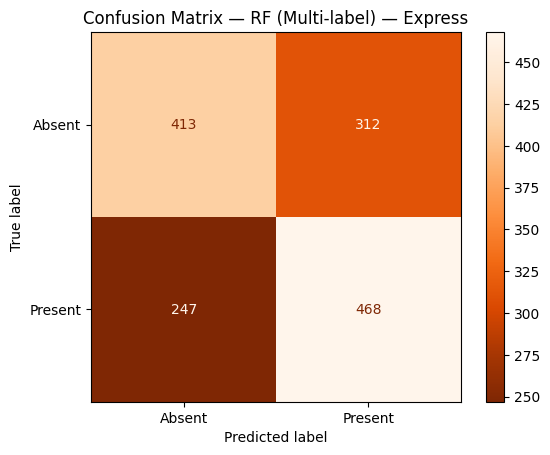

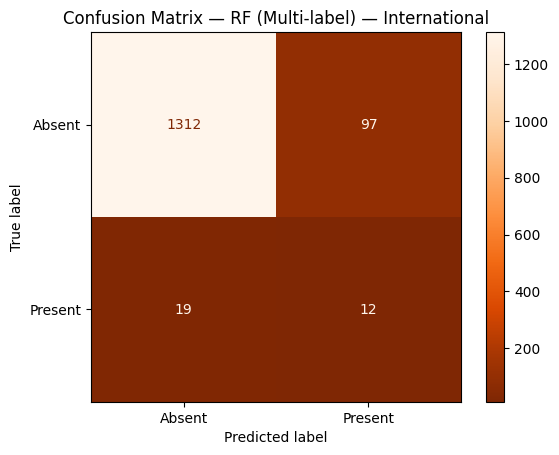

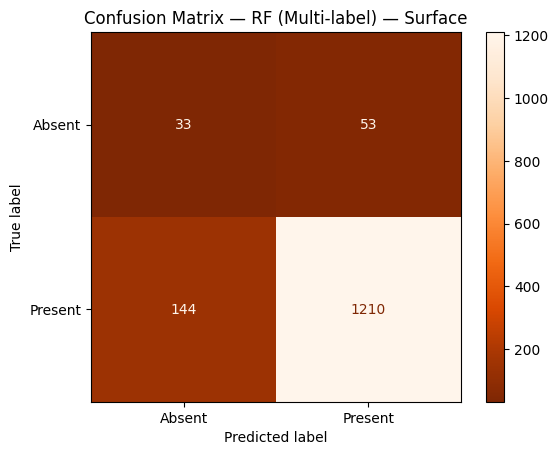

In [ ]:
# Plot confusion matrices for Random Forest
Y_pred_rf_ml = rf_pipeline.predict(X_test)

for i, col in enumerate(shipment_cols):
    cm = confusion_matrix(
        Y_test.iloc[:, i],
        Y_pred_rf_ml[:, i]
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Absent", "Present"]
    )

    disp.plot(cmap="Oranges_r")
    plt.title(f"Confusion Matrix — RF (Multi-label) — {col}")
    plt.show()

PR curve for Logistic Regression

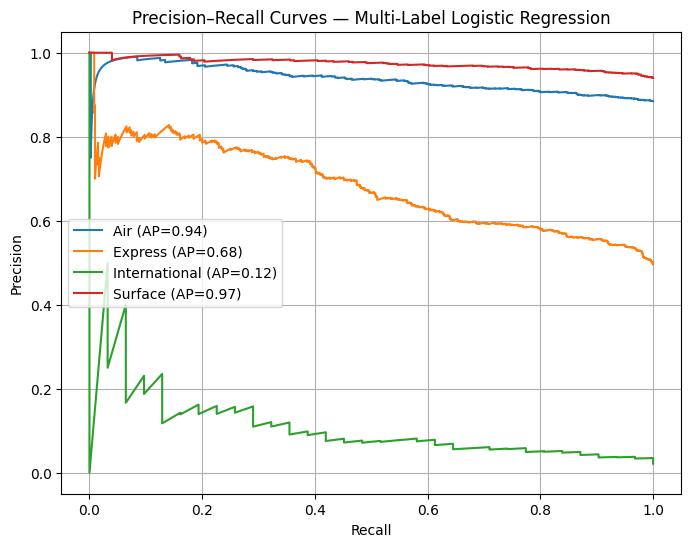

In [ ]:
# Get predicted probabilities for LR evaluation
Y_test_pred_proba_lr = lr_pipeline.predict_proba(X_test)
#PR curve
plt.figure(figsize=(8, 6))

for j, col in enumerate(shipment_cols):
    y_true = Y_test.iloc[:, j]
    y_score = Y_test_pred_proba_lr[:, j]

    precision, recall, _ = precision_recall_curve(
        y_true,
        y_score
    )

    ap = average_precision_score(
        y_true,
        y_score
    )

    plt.plot(
        recall,
        precision,
        label=f"{col} (AP={ap:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Multi-Label Logistic Regression")
plt.legend()
plt.grid()
plt.show()

Confusion matrix for Logistic regression

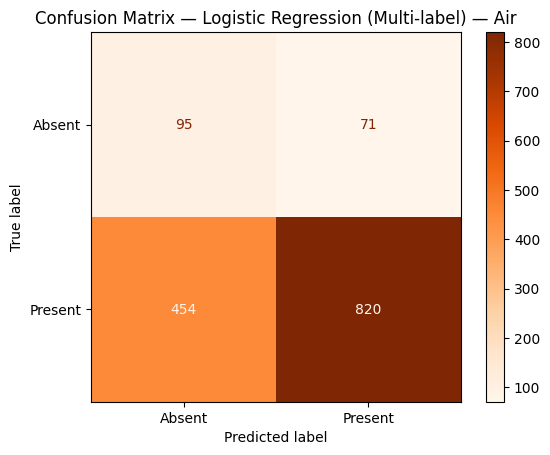

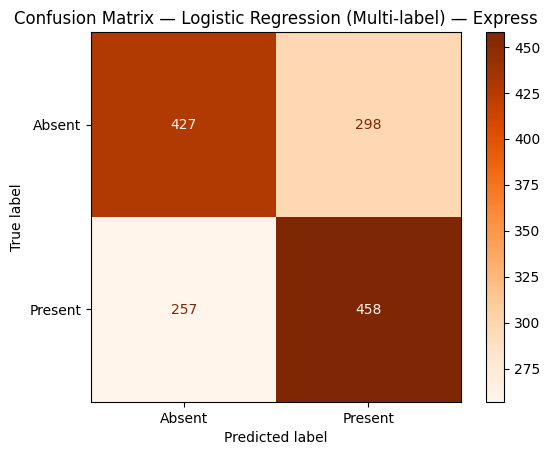

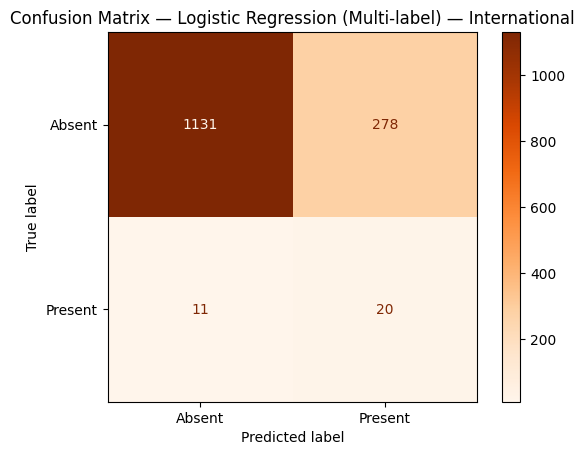

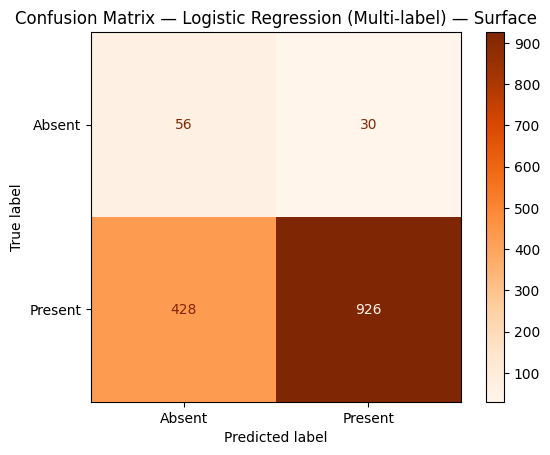

In [ ]:
# Plot confusion matrices for Logistic Regression
Y_pred_lr_ml = lr_pipeline.predict(X_test)
# confusion matrix
for i, col in enumerate(shipment_cols):
    cm = confusion_matrix(
        Y_test.iloc[:, i],
        Y_pred_lr_ml[:, i]
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Absent", "Present"]
    )

    disp.plot(cmap="Oranges")
    plt.title(f"Confusion Matrix — Logistic Regression (Multi-label) — {col}")
    plt.show()

## 7. Final Prediction Interface

The final system takes a company name as input and outputs:
- Next booking date (deterministic)
- Probabilities for each shipment type

This design reflects real operational usage and uncertainty.


In [ ]:
# Function to predict next booking for a given company
def predict_next_booking_multilabel(company_name, threshold=0.20):
    company_data = daily_pivot[daily_pivot["company_name"] == company_name]
    if company_data.empty:
        raise ValueError("Company not found")

    last_date = company_data["booking_date"].max()
    next_date = last_date + pd.Timedelta(days=1)

    recent = company_data.sort_values("booking_date").iloc[-30:]

    row = {
        "company_enc": le_company.transform([company_name])[0],
        "day_of_week": next_date.weekday(),
        "is_weekend": int(next_date.weekday() in [5, 6]),
        "month_sin": np.sin(2 * np.pi * next_date.month / 12),
        "month_cos": np.cos(2 * np.pi * next_date.month / 12),
        "orders_avg_7d": recent["total_orders"].tail(7).mean(),
        "orders_avg_30d": recent["total_orders"].mean()
    }

    for col in shipment_cols:
        row[f"{col}_ratio_7d"] = recent[col].tail(7).sum()
        row[f"{col}_ratio_30d"] = recent[col].sum()

    X_input = pd.DataFrame([row])[feature_cols]

    probs = rf_pipeline.predict_proba(X_input)  
    result = {}
    for i, col in enumerate(shipment_cols):
        result[col] = float(probs[0][i])   

    return {
        "next_booking_date": next_date.date(),
        "shipment_probabilities": result,
        "predicted_shipments": [
            k for k, v in result.items() if v >= threshold
        ]
    }

## Use case

1.

In [ ]:
# Test prediction for BlueDart
predict_next_booking_multilabel("BlueDart")

{'next_booking_date': datetime.date(2026, 1, 1),
 'shipment_probabilities': {'Air': 0.556740793733905,
  'Express': 0.4913681472014211,
  'International': 0.1616682180119028,
  'Surface': 0.6153189699478168},
 'predicted_shipments': ['Air', 'Express', 'Surface']}

2.

In [ ]:
# Test prediction for Shadowfax
predict_next_booking_multilabel("Shadowfax")

{'next_booking_date': datetime.date(2026, 1, 1),
 'shipment_probabilities': {'Air': 0.6184337056445356,
  'Express': 0.32743389706244164,
  'International': 0.7027683078577196,
  'Surface': 0.3532752163704738},
 'predicted_shipments': ['Air', 'Express', 'International', 'Surface']}

## 8. Final Conclusion

In this project, the goal was to understand and predict shipment behavior using historical booking data.
After analyzing the data, it became clear that all companies place bookings every day without meaningful gaps. Because of this, predicting the next booking date is unnecessary, and the next booking day can be reliably taken as the last available booking date plus one day.

Instead of forcing each day into a single shipment category, the problem was approached as a multi-label prediction task, where multiple shipment types can occur on the same day. This better reflects real logistics operations, where different shipment modes often coexist rather than compete with each other.

To capture shipment patterns, time-based features such as weekdays, seasonal trends, and recent booking behavior were used. These features helped the models learn meaningful patterns without relying on future information. Both Logistic Regression and Random Forest performed well under this setup, with Logistic Regression offering clear interpretability and Random Forest capturing more complex interactions.